In [3]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pylab
import glob, os
import scipy.stats as stats
from scipy.stats import gaussian_kde
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import chi2
from sklearn.metrics import r2_score
import timeit
%matplotlib inline

In [4]:
# Format to remove scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Read data

In [5]:
data1 = pd.read_csv(r'R:\Angela\KCMetro\2015_04_28.csv')
data1['date_id'] = 1
data2 = pd.read_csv(r'R:\Angela\KCMetro\2015_04_29.csv')
data2['date_id'] = 2
data3 = pd.read_csv(r'R:\Angela\KCMetro\2015_04_30.csv')
data3['date_id'] = 3
data4 = pd.read_csv(r'R:\Angela\KCMetro\2015_05_05.csv')
data4['date_id'] = 4
data5 = pd.read_csv(r'R:\Angela\KCMetro\2015_05_06.csv')
data5['date_id'] = 5
data6 = pd.read_csv(r'R:\Angela\KCMetro\2015_05_07.csv')
data6['date_id'] = 6

In [6]:
for data in [data1, data2, data3, data4, data5, data6]:
    print len(data)

581968
582850
583272
584437
582514
585595


# Fleet type - Capacity info

In [7]:
fleet = pd.read_csv(r'R:\Angela\KCMetro\fleet.csv')

In [8]:
def fleet_type(data):
    #get fleet type info
    fleet_dict = {}
    for ele in np.unique(data.VEHICLE_ID):
        for a in fleet.fleet_a:
            b = int(fleet[fleet.fleet_a == a].fleet_b)
            if a <= ele <= b:
                fleet_dict[ele] = int(fleet[fleet.fleet_a == a]['Total Capacity'])
    print 'fleet_dict length', len(fleet_dict)
    print 'unique vehicle number', len(np.unique(data.VEHICLE_ID))
    #sign fleet types to vehicles
    print data.shape
    for ele in np.unique(data.VEHICLE_ID):
        if ele in fleet_dict:
            continue
        else:
            print ele
            #print data[data.VEHICLE_ID == ele]
    data['capacity'] = data['VEHICLE_ID'].map(fleet_dict)
    print data.shape
    
    return data

In [9]:
#fleet_data = fleet_type(data)

In [10]:
#fleet_data.columns

# Route Type

In [15]:
route = pd.read_csv(r'R:\Angela\KCMetro\151AllTrips.csv')

In [16]:
rapid_list = [671, 672, 673, 674, 675, 676]
for rte in rapid_list:
    route.loc[route['Rte'] == rte, 'E/L'] = 'R'
dict_route_type = route.set_index('TRIP_ID').to_dict()['E/L']

In [17]:
# Pre-check: there are TRIP_IDs not included in the 151ALLTrips.csv
'''
def check_lefttrips(data):
    j = 0
    left_rte = {}
    for trip in np.unique(data.TRIP_ID):
        if trip in dict_route_type:
            continue
        else:
            #print trip
            left_rte[trip] = int(np.unique(data[data.TRIP_ID == trip]['RTE']))
            #print len(data[data.TRIP_ID == trip])
            j = len(data[data.TRIP_ID == trip]) + j
    print left_rte
    print 'APC records lenth', j

check_lefttrips(fleet_data)  
    
'''

"\ndef check_lefttrips(data):\n    j = 0\n    left_rte = {}\n    for trip in np.unique(data.TRIP_ID):\n        if trip in dict_route_type:\n            continue\n        else:\n            #print trip\n            left_rte[trip] = int(np.unique(data[data.TRIP_ID == trip]['RTE']))\n            #print len(data[data.TRIP_ID == trip])\n            j = len(data[data.TRIP_ID == trip]) + j\n    print left_rte\n    print 'APC records lenth', j\n\ncheck_lefttrips(fleet_data)  \n    \n"

In [18]:
def route_type(data):
    data['Route Type'] = data['TRIP_ID'].map(dict_route_type) 
    print data['Route Type'] .isnull().sum()
    print data.shape
    data = data.dropna(subset=['Route Type'])
    #data['Route Type'] = data['Route Type'].dropna()
    print data.shape
    
    return data

In [19]:
#route_data = route_type(fleet_data)

In [20]:
# Post-check

'''
print np.unique(route_data['Route Type'])
print route_data.columns
'''

"\nprint np.unique(route_data['Route Type'])\nprint route_data.columns\n"

# my_data

In [29]:
def content_need(data):
    data = data[['TRIP_ID', 'RTE', 'VEHICLE_ID', 'BUS_TYPE', 'NUM_DOORS', 
                 'STOP_SEQ', 'STOP_ID','DWELL_SEC', 'DOOR_OPEN_SEC', 
                 'ONS', 'OFFS', 'LOAD', 'date_id', 'capacity', 'Route Type']]
    return data

In [21]:
#my_data = content_need(route_data)

# Data preparation

# Step1: Clean data

In [22]:
def clean_data(data):
    start = timeit.default_timer()
    
    #get fleet and vehicle type info
    data = fleet_type(data)
    data = route_type(data)
    data = content_need(data)
    
    # Before cleaning records, get the load data from the previous stop
    data = data.sort(['TRIP_ID', 'STOP_SEQ'])
    data['pre_load'] = data['LOAD'].shift()
    
    # Remove the corner data (fist and last stops) before the data was disordered by other cleaning processes
    def del_stop(data):
        return data.iloc[1:-1]
    data = data.groupby('TRIP_ID', group_keys=False).apply(del_stop)
    print 'clean first and last stops', data.shape
    
    #data = data[pd.notnull(data['pre_load'])]
    #print 'clean invalid pre_load', data.shape
    
    # 0< Dwell time < 120 
    data = data[data['DOOR_OPEN_SEC'] != 0]
    #data = data[data['DOOR_OPEN_SEC'] != 0]
    print 'cleaned zero dwell', data.shape
    data = data[data['DOOR_OPEN_SEC'] <= 120]
    #data = data[data['DOOR_OPEN_SEC'] <= 120]
    print 'cleaned large dwell', data.shape
    
    # On + off != 0
    data = data[pd.notnull(data['ONS'])]
    data = data[data['ONS'] + data['OFFS'] != 0]
    print 'cleaned the invalid or zero boarding+alighting records:', data.shape
    
    # valid bus type
    data = data[data.BUS_TYPE != '??']
    print 'cleaned unknow bus type', data.shape
    
    # delete all downtown tunnel stop records
    dict_stop_id = dict((el,1) for el in [455, 456, 501, 502, 532, 533, 565, 566, 621, 622, 623, 624, 
                                      1082, 1083, 1084, 1086, 1108, 1109, 1121, 1122, 1192, 1193])
    data['downtown_stop'] = data['STOP_ID'].map(dict_stop_id)
    data.downtown_stop = data.downtown_stop.fillna(0)
    data = data[data.downtown_stop != 1]
    print 'cleaned downtown tunnel', data.shape
    stop = timeit.default_timer()
    print 'removed invalid data:', stop - start
    
    return data

# Step2: Prepare basic variables

In [23]:
def get_x_y(data): 
    start = timeit.default_timer()
    
    # Bus type: Articulated or Standard bus; TWo or Three doors; fleet
    data['Artic'] = data['BUS_TYPE'].map({'Artic': 1, 'Standard': 0})
    data['twodoors'] = data['NUM_DOORS'].map({2: 1, 3: 0})
    data['threedoors'] = data['NUM_DOORS'].map({2: 0, 3: 1})
    data['twodoors_artic'] = data['twodoors'] * data['Artic']
    data['threedoors_artic'] = data['threedoors'] * data['Artic']
    
    # Route Type, create dummie variables for each route type
    just_dummies_route = pd.get_dummies(data['Route Type'])
    step_1 = pd.concat([data, just_dummies_route], axis=1)
    # Avoid dummie variable trap
    step_1.drop(['L'], inplace=True, axis=1)
    data = step_1
    stop = timeit.default_timer()
    print 'add veh&route info:', stop - start
    
    start = timeit.default_timer()
    # Passenger activity
    data['ON+OFF'] = data['ONS'] + data['OFFS']
    data['ma_pasg'] = data[['ONS', 'OFFS']].max(axis=1)
    data['ab_pasg'] = (data['ONS'] - data['OFFS']).abs()
    data['pre_standees']= data['pre_load'] - 0.60 * data['capacity']
    data['pre_crowding']= data.apply(lambda x: x['pre_standees'] > 0, axis=1).map({False: 0, True: 1})
    data['friction'] = ((data['ONS'] + data['OFFS'] + (data['pre_standees']).abs()) * data['pre_crowding']).abs()
    print data.shape
    
    # Interactive vars
    data['On_twodoors_artic'] = data['ONS'] * data['twodoors_artic']
    data['Off_twodoors_artic'] = data['OFFS'] * data['twodoors_artic']
    data['on_threedoors_artic'] = data['ONS'] * data['threedoors_artic']
    data['off_threedoors_artic'] = data['OFFS'] * data['threedoors_artic']
    data['on_express'] = data['ONS']*data['E']
    data['off_express'] = data['OFFS']*data['E']
    data['on_rapid'] = data['ONS']*data['R']
    data['off_rapid'] = data['OFFS']*data['R']
    #data['OnsDowntown'] = data['ONS'] * data['downtown_stop']
    #data['OffsDowntown'] = data['OFFS'] * data['downtown_stop']
    print data.shape
    stop = timeit.default_timer()
    print 'add correlation variables:', stop - start
    
    return data

# Step3: Prepare control variable: Vehnicle ID

In [24]:
# Create dummie variables for bus id 
def create_vehID(data):
    start = timeit.default_timer()
    print 'data shape:', data.shape
    data['vehno_date'] = data.VEHICLE_ID.astype(str) + '_' + data.date_id.astype(str)
    print len(np.unique(data.vehno_date))
    just_dummies_veh = pd.get_dummies(data['vehno_date'])
    data = pd.concat([data, just_dummies_veh], axis=1)
    stop = timeit.default_timer()
    print 'data shape:', data.shape
    print 'add vehid variables:', stop - start
    
    return data

# Step4: Delete a vehicle variable in each bus type

In [25]:
# Get the bus IDs, who only runs one route type in a day, and delete them. 
def del_veh(data):
    df_std = data.loc[data.Artic == 0]
    df_art_2d= data.loc[(data.Artic == 1) & (data.twodoors == 1)]
    df_art_3d = data.loc[(data.Artic == 1) & (data.twodoors == 0)]
    # Find out the del-needed veh_date
    del_dict = {}
    i = 1
    for df in [df_std, df_art_2d, df_art_3d]:
        print np.unique(df['Route Type'])
        for veh_day in np.unique(df.vehno_date):
            df_veh = df.loc[df.vehno_date == veh_day]
            if (len(np.unique(df_veh['Route Type'])) == 1):
                rte_type = np.unique(df_veh['Route Type'])
                val = str(rte_type) + '_' + str(i)
                del_dict[val] = veh_day
        print del_dict
        i += 1
    print del_dict
    # Delete the vehicle_date IDs
    print data.shape
    data = data.drop(del_dict.values(), 1)
    print data.shape
    
    return data

# prepare data

In [32]:
df_base = pd.DataFrame(columns = ['TRIP_ID', 'RTE', 'VEHICLE_ID', 'BUS_TYPE', 'NUM_DOORS',
                                  'STOP_SEQ', 'STOP_ID', 'DWELL_SEC', 'DOOR_OPEN_SEC', 
                                  'ONS', 'OFFS', 'LOAD', 'date_id', 'capacity', 
                                  'Route Type', 'pre_load','downtown_stop'])
print len(df_base)
for my_data in [data1, data2, data3, data4, data5, data6]:
    print len(my_data)
    
    my_data = clean_data(my_data)
    print my_data.columns
    df_base = pd.concat([df_base, my_data])
    print len(df_base)


0
581968
fleet_dict length 1223
unique vehicle number 1223
(581968, 32)
(581968, 33)
39
(581968, 34)
(581929, 34)
clean first and last stops (560931, 16)
cleaned zero dwell (209743, 16)
cleaned large dwell (201166, 16)
cleaned the invalid or zero boarding+alighting records: (61055, 16)
cleaned unknow bus type (59766, 16)
cleaned downtown tunnel (57663, 17)
removed invalid data: 34.0364011935
Index([u'TRIP_ID', u'RTE', u'VEHICLE_ID', u'BUS_TYPE', u'NUM_DOORS', u'STOP_SEQ', u'STOP_ID', u'DWELL_SEC', u'DOOR_OPEN_SEC', u'ONS', u'OFFS', u'LOAD', u'date_id', u'capacity', u'Route Type', u'pre_load', u'downtown_stop'], dtype='object')
57663
582850
fleet_dict length 1219
unique vehicle number 1219
(582850, 32)
(582850, 33)
403
(582850, 34)
(582447, 34)
clean first and last stops (561541, 16)
cleaned zero dwell (211099, 16)
cleaned large dwell (202496, 16)
cleaned the invalid or zero boarding+alighting records: (58191, 16)
cleaned unknow bus type (56893, 16)
cleaned downtown tunnel (54940, 17)
r

In [33]:
df_base.columns

Index([u'TRIP_ID', u'RTE', u'VEHICLE_ID', u'BUS_TYPE', u'NUM_DOORS', u'STOP_SEQ', u'STOP_ID', u'DWELL_SEC', u'DOOR_OPEN_SEC', u'ONS', u'OFFS', u'LOAD', u'date_id', u'capacity', u'Route Type', u'pre_load', u'downtown_stop'], dtype='object')

In [34]:
step2 = get_x_y(df_base)

add veh&route info: 0.910398121502
(335888, 30)
(335888, 38)
add correlation variables: 4.58878480253


In [35]:
step2.columns

Index([u'TRIP_ID', u'RTE', u'VEHICLE_ID', u'BUS_TYPE', u'NUM_DOORS', u'STOP_SEQ', u'STOP_ID', u'DWELL_SEC', u'DOOR_OPEN_SEC', u'ONS', u'OFFS', u'LOAD', u'date_id', u'capacity', u'Route Type', u'pre_load', u'downtown_stop', u'Artic', u'twodoors', u'threedoors', u'twodoors_artic', u'threedoors_artic', u'E', u'R', u'ON+OFF', u'ma_pasg', u'ab_pasg', u'pre_standees', u'pre_crowding', u'friction', u'On_twodoors_artic', u'Off_twodoors_artic', u'on_threedoors_artic', u'off_threedoors_artic', u'on_express', u'off_express', u'on_rapid', u'off_rapid'], dtype='object')

In [36]:
step3 = create_vehID(step2)

data shape: (335888, 38)
2314
data shape: (335888, 2353)
add vehid variables: 42.9131053477


In [38]:
step4 = del_veh(step3)

['E' 'L']
{"['E']_1": '9090.0_3.0', "['L']_1": '7215.0_6.0'}
['E' 'L']
{"['E']_1": '9090.0_3.0', "['L']_1": '7215.0_6.0', "['L']_2": '6949.0_6.0', "['E']_2": '9651.0_6.0'}
['L' 'R']
{"['L']_1": '7215.0_6.0', "['L']_2": '6949.0_6.0', "['L']_3": '4209.0_6.0', "['E']_1": '9090.0_3.0', "['E']_2": '9651.0_6.0', "['R']_3": '6117.0_6.0'}
{"['L']_1": '7215.0_6.0', "['L']_2": '6949.0_6.0', "['L']_3": '4209.0_6.0', "['E']_1": '9090.0_3.0', "['E']_2": '9651.0_6.0', "['R']_3": '6117.0_6.0'}
(335888, 2353)
(335888, 2347)


In [ ]:
# Save the "ready-to-model" data
step4.to_csv(r'R:/Angela/fast_trips/KCMetro_final_data.csv')

In [39]:
my_project = step4

# Create training (70%) and validating (30%) dataset 

In [41]:
msk = np.random.rand(len(my_project)) < 0.7
df_train = my_project[msk]
df_test = my_project[~msk]

In [42]:
print df_train.shape
print df_test.shape

(235391, 2347)
(100497, 2347)


In [43]:
df_train.columns[:40]

Index([u'TRIP_ID', u'RTE', u'VEHICLE_ID', u'BUS_TYPE', u'NUM_DOORS', u'STOP_SEQ', u'STOP_ID', u'DWELL_SEC', u'DOOR_OPEN_SEC', u'ONS', u'OFFS', u'LOAD', u'date_id', u'capacity', u'Route Type', u'pre_load', u'downtown_stop', u'Artic', u'twodoors', u'threedoors', u'twodoors_artic', u'threedoors_artic', u'E', u'R', u'ON+OFF', u'ma_pasg', u'ab_pasg', u'pre_standees', u'pre_crowding', u'friction', u'On_twodoors_artic', u'Off_twodoors_artic', u'on_threedoors_artic', u'off_threedoors_artic', u'on_express', u'off_express', u'on_rapid', u'off_rapid', u'vehno_date', u'1100.0_1.0'], dtype='object')

# Build multi-linear regression model

# Model 1 - with vehicle ids

Create a LinearRegression object 

In [46]:
# Run Linear Regression In Python SciKit-Learn
start = timeit.default_timer()
df_train = df_train.dropna()
df_test = df_test.dropna()
X_train = df_train.drop(['TRIP_ID','RTE','VEHICLE_ID', 'BUS_TYPE', 'NUM_DOORS','STOP_SEQ',
                         'STOP_ID','DWELL_SEC','DOOR_OPEN_SEC', 'pre_load', 'LOAD', 'date_id', 'capacity', 
                         'downtown_stop', 'ON+OFF', 'Artic','twodoors', 'threedoors', 'ma_pasg','ab_pasg',
                        'pre_standees', 'pre_crowding','vehno_date', 'Route Type'], axis=1)

X_test = df_test.drop(['TRIP_ID','RTE','VEHICLE_ID', 'BUS_TYPE', 'NUM_DOORS','STOP_SEQ',
                         'STOP_ID','DWELL_SEC','DOOR_OPEN_SEC', 'pre_load','LOAD', 'date_id', 'capacity', 
                         'downtown_stop', 'ON+OFF', 'Artic','twodoors', 'threedoors', 'ma_pasg','ab_pasg',
                        'pre_standees', 'pre_crowding','vehno_date', 'Route Type'], axis=1)

y_train = df_train.DOOR_OPEN_SEC
y_test = df_test.DOOR_OPEN_SEC

stop = timeit.default_timer()
print 'prepare x,y for regression:', stop - start

prepare x,y for regression: 603.923590685


In [47]:
len(df_train)

235391

Run Linear Regression In Python SciKit-Learn

In [48]:
start = timeit.default_timer()
lm1 = LinearRegression()
lm1.fit(X_train, y_train)
pred_train = lm1.predict(X_train)
pred_test = lm1.predict(X_test)
LinearRegression(copy_X=True, fit_intercept=True,normalize=False)

# Construct a data frame that contains features and estimated coefficients
sklearn_results1 = pd.DataFrame(zip(X_train.columns, lm1.coef_), columns = ['features', 'estimatedCoefficients'])
# p-values
scores, pvalues = chi2(X_train, y_train)
sklearn_results1['pvalues'] = pd.DataFrame(pvalues)
sklearn_results1['scores'] = pd.DataFrame(scores)

stop = timeit.default_timer()
print 'build model with veh&day ids:', stop - start

build model with veh&day ids: 210.887033421


In [49]:
print sklearn_results1

                  features  estimatedCoefficients  pvalues     scores
0                      ONS                  3.243    0.000 464820.493
1                     OFFS                  1.438    0.000 141409.678
2           twodoors_artic                  1.469    0.000   1156.744
3         threedoors_artic                  5.868    0.000   2787.774
4                        E                  1.329    0.000   1597.173
5                        R                 -2.067    0.000   1699.156
6                 friction                 -0.075    0.000 131294.346
7        On_twodoors_artic                 -0.320    0.000 225663.922
8       Off_twodoors_artic                 -0.348    0.000  74639.100
9      on_threedoors_artic                 -0.073    0.000 174415.475
10    off_threedoors_artic                  0.018    0.000  63457.651
11              on_express                 -0.392    0.000 146891.736
12             off_express                 -0.244    0.000  51404.710
13                on

In [ ]:
sklearn_results1.to_csv('R:/Angela/fast_trips/KCMetro/Final_withVeh_friction.csv')

In [51]:
R2 = r2_score(y_train, pred_train) 
print R2

0.442393859767


# Correlation 

In [52]:
c = X_train.corr().abs()
s = c.unstack()
so = s.order(kind="quicksort")

In [53]:
print len(so)
soo = so.dropna()
soo = soo[soo >= 0.500]
soo = soo[soo != 1.0]
print len(soo)

5396329
28


In [54]:
soo

on_express            E                      0.502
E                     on_express             0.502
R                     on_rapid               0.504
on_rapid              R                      0.504
off_threedoors_artic  OFFS                   0.506
OFFS                  off_threedoors_artic   0.506
off_threedoors_artic  threedoors_artic       0.511
threedoors_artic      off_threedoors_artic   0.511
R                     off_rapid              0.521
off_rapid             R                      0.521
on_rapid              ONS                    0.546
ONS                   on_rapid               0.546
                      On_twodoors_artic      0.573
On_twodoors_artic     ONS                    0.573
on_threedoors_artic   ONS                    0.584
ONS                   on_threedoors_artic    0.584
Off_twodoors_artic    OFFS                   0.657
OFFS                  Off_twodoors_artic     0.657
on_express            On_twodoors_artic      0.676
On_twodoors_artic     on_expres

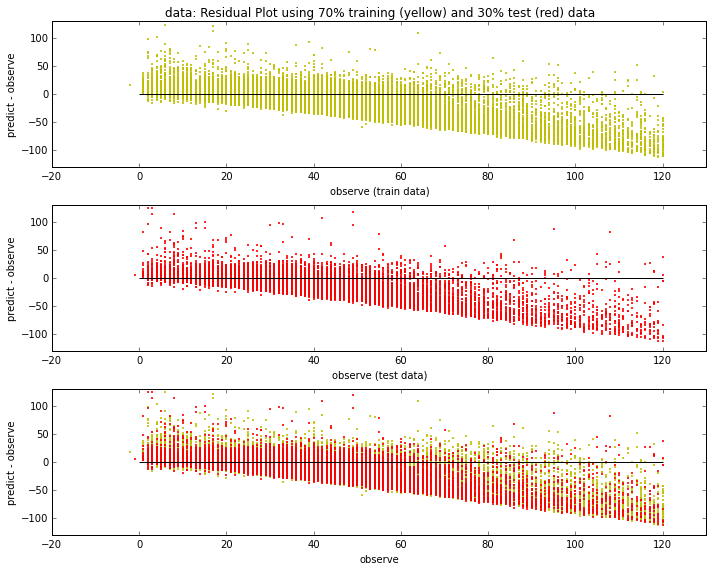

In [87]:
plt.figure(1)

plt.subplot(311)
plt.scatter(y_train, lm1.predict(X_train) - y_train, c='y', s=1,edgecolor='y')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.title('data: Residual Plot using 70% training (yellow) and 30% test (red) data')
plt.ylabel('predict - observe')
plt.xlabel('observe (train data)')

plt.subplot(312)
plt.scatter(y_test, lm1.predict(X_test) - y_test, c='r', s=1,edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe (test data)')

plt.subplot(313)
plt.scatter(y_train, lm1.predict(X_train) - y_train, c='y', s=1, edgecolor='y')
plt.scatter(y_test, lm1.predict(X_test) - y_test, c='r', s=1, edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe')

plt.tight_layout()
plt.figure(figsize=(10,5))
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.show()

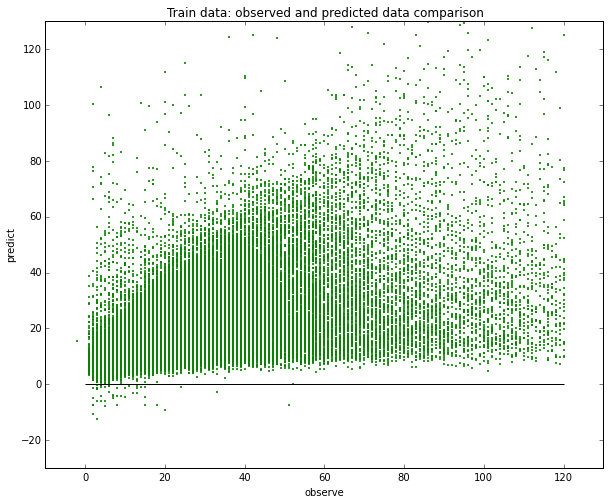

In [57]:
plt.figure(1)

plt.scatter(y_train, lm1.predict(X_train), c='y', s=1,edgecolor='g')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-10, 130, -30, 130])
plt.title('Train data: observed and predicted data comparison')
plt.ylabel('predict')
plt.xlabel('observe')
plt.figure(figsize=(10,5))
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.show()

In [97]:
'''
x = y_test
y = lm1.predict(X_test)

# Calculate the point density
start = timeit.default_timer()
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
stop = timeit.default_timer()
print 'finished calculating z:', stop - start

# Sort the points by density, so that the densest points are plotted last
start = timeit.default_timer()
idx = z.argsort()
stop = timeit.default_timer()
print 'finished sorting data:', stop - start

x, y, z = x[idx], y[idx], z[idx]
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=5, edgecolor='')
plt.axis([0, 130, 0, 130])
plt.title('Test data: scatter plot colored by density')
plt.ylabel('predict')
plt.xlabel('observe')
plt.show()
'''

finished calculating z: 77.3669889485
finished sorting data: 0.00343622384798


ValueError: cannot reindex from a duplicate axis

# Model2 - without vehicle ID

In [61]:
X2_train = df_train[['ONS', 'OFFS', 'threedoors_artic', 'twodoors_artic', 'E', 'R', 
                     'friction','On_twodoors_artic', 'Off_twodoors_artic', 
                     'on_threedoors_artic', 'off_threedoors_artic', 'on_express', 
                     'off_express', 'on_rapid', 'off_rapid']]

X2_test = df_test[['ONS', 'OFFS', 'threedoors_artic', 'twodoors_artic', 'E', 'R', 
                     'friction','On_twodoors_artic', 'Off_twodoors_artic', 
                     'on_threedoors_artic', 'off_threedoors_artic', 'on_express', 
                     'off_express', 'on_rapid', 'off_rapid']]
y2_train = y_train
y2_test = y_test

In [62]:
start = timeit.default_timer()
lm2 = LinearRegression()
lm2.fit(X2_train, y2_train)
pred_train2 = lm2.predict(X2_train)
pred_test2 = lm2.predict(X2_test)
LinearRegression(copy_X=True, fit_intercept=True,normalize=False)

# Construct a data frame that contains features and estimated coefficients
sklearn_results2 = pd.DataFrame(zip(X2_train.columns, lm2.coef_), columns = ['features', 'estimatedCoefficients'])
# p-values
scores, pvalues = chi2(X2_train, y2_train)
sklearn_results2['pvalues'] = pd.DataFrame(pvalues)
sklearn_results2['scores'] = pd.DataFrame(scores)

stop = timeit.default_timer()
print 'build model with veh&day ids:', stop - start

build model with veh&day ids: 1.18598329832


In [63]:
print sklearn_results2

                features  estimatedCoefficients  pvalues     scores
0                    ONS                  3.277    0.000 464820.493
1                   OFFS                  1.480    0.000 141409.678
2       threedoors_artic                  3.005    0.000   2787.774
3         twodoors_artic                  0.549    0.000   1156.744
4                      E                  0.788    0.000   1597.173
5                      R                 -1.620    0.000   1699.156
6               friction                 -0.073    0.000 131294.346
7      On_twodoors_artic                 -0.365    0.000 225663.922
8     Off_twodoors_artic                 -0.408    0.000  74639.100
9    on_threedoors_artic                 -0.123    0.000 174415.475
10  off_threedoors_artic                 -0.044    0.000  63457.651
11            on_express                 -0.357    0.000 146891.736
12           off_express                 -0.208    0.000  51404.710
13              on_rapid                 -0.998 

In [ ]:
sklearn_results2.to_csv('R:/Angela/fast_trips/KCMetro/Final_withoutVeh_friction.csv')

In [64]:
# R-square
R22 = r2_score(y2_train, pred_train2) 
print R22

0.420885342956


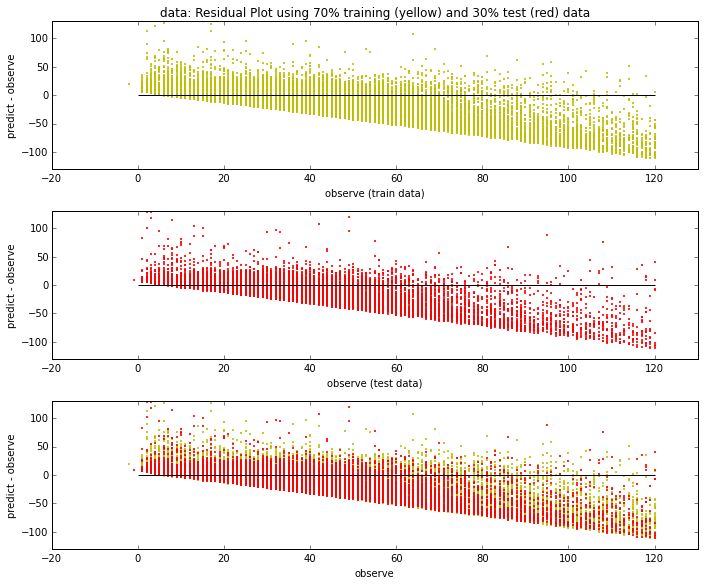

In [65]:
plt.figure(1)
plt.subplot(311)
plt.scatter(y2_train, lm2.predict(X2_train) - y2_train, c='y', s=1,edgecolor='y')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.title('data: Residual Plot using 70% training (yellow) and 30% test (red) data')
plt.ylabel('predict - observe')
plt.xlabel('observe (train data)')

plt.subplot(312)
plt.scatter(y2_test, lm2.predict(X2_test) - y2_test, c='r', s=1,edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe (test data)')

plt.subplot(313)
plt.scatter(y2_train, lm2.predict(X2_train) - y2_train, c='y', s=1, edgecolor='y')
plt.scatter(y2_test, lm2.predict(X2_test) - y2_test, c='r', s=1, edgecolor='r')

plt.tight_layout()
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe')

plt.show()

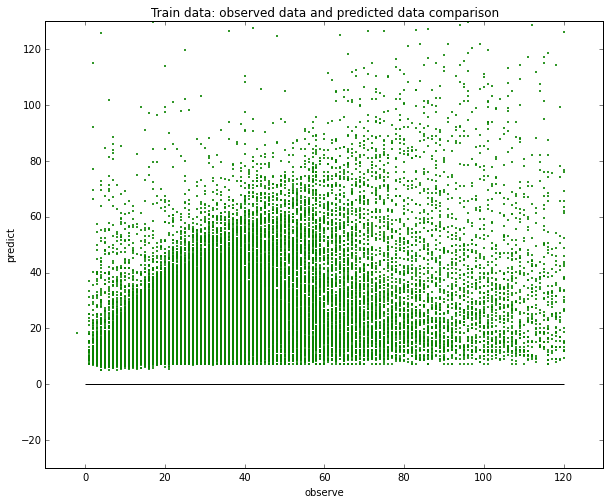

In [66]:
plt.figure(1)

plt.scatter(y2_train, lm2.predict(X2_train), c='y', s=1,edgecolor='g')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-10, 130, -30, 130])
plt.title('Train data: observed data and predicted data comparison')
plt.ylabel('predict')
plt.xlabel('observe')
plt.show()

In [67]:
#density plots
'''
x2 = y2_test
y2 = lm2.predict(X2_test)

# Calculate the point density
start = timeit.default_timer()
xy2 = np.vstack([x2,y2])
z2 = gaussian_kde(xy2)(xy2)
stop = timeit.default_timer()
print 'z:', stop - start

# Sort the points by density, so that the densest points are plotted last
start = timeit.default_timer()
idx = z2.argsort()
stop = timeit.default_timer()
print 'sort data:', stop - start

x2, y2, z2 = x2[idx], y2[idx], z2[idx]
fig, ax = plt.subplots()
ax.scatter(x2, y2, c=z2, s=5, edgecolor='')

plt.axis([0, 130, 0, 130])
plt.title('Test dataset: scatter plot colored by density')
plt.ylabel('predict')
plt.xlabel('observe')

plt.show()
'''

z: 652.135111315
sort data: 0.00909800321097


ValueError: cannot reindex from a duplicate axis

# Plotting Scatter, by appling the dewell time model with the rest 30% data

In [73]:
#try the [door_open_sec] as y variable!
lm3 = smf.ols(formula = 'DOOR_OPEN_SEC ~ ONS + OFFS + threedoors_artic + twodoors_artic + friction + On_twodoors_artic + Off_twodoors_artic + on_threedoors_artic + off_threedoors_artic + on_rapid + off_rapid', data = df_train).fit()
print lm3.summary()

                            OLS Regression Results                            
Dep. Variable:          DOOR_OPEN_SEC   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                 1.547e+04
Date:                Thu, 17 Mar 2016   Prob (F-statistic):               0.00
Time:                        14:53:16   Log-Likelihood:            -9.0685e+05
No. Observations:              235391   AIC:                         1.814e+06
Df Residuals:                  235379   BIC:                         1.814e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                5.7448 

In [80]:
X3_train = df_train[['ONS', 'OFFS', 'Artic','ON+OFF', 'threedoors_artic', 'twodoors_artic','friction', 
                     'On_twodoors_artic','Off_twodoors_artic', 'on_threedoors_artic', 'off_threedoors_artic', 
                     'on_rapid', 'off_rapid']]
X3_test = df_test[['ONS', 'OFFS', 'Artic','ON+OFF', 'R', 'E', 'threedoors_artic', 'twodoors_artic','friction', 
                     'On_twodoors_artic','Off_twodoors_artic', 'on_threedoors_artic', 'off_threedoors_artic', 
                     'on_rapid', 'off_rapid']]
y3_train = y_train
y3_test = y_test

In [81]:
#Estimate dwell time for the 'test' dataset
df_est = []
df_est = pd.DataFrame(lm3.predict(X3_test), index = X3_test.index, columns = ['Dwell_Time_Esti'])
test = pd.concat([X3_test, df_est], axis=1, join='inner')
test.head()

,ONS,OFFS,Artic,ON+OFF,R,E,threedoors_artic,twodoors_artic,friction,On_twodoors_artic,Off_twodoors_artic,on_threedoors_artic,off_threedoors_artic,on_rapid,off_rapid,Dwell_Time_Esti
253293,2.000,2.000,0,4.000,0.000,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,15.198
253387,2.000,0.000,0,2.000,0.000,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,12.259
253408,0.000,10.000,0,10.000,0.000,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,20.438
253425,3.000,1.000,0,4.000,0.000,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,16.986
314282,4.000,0.000,0,4.000,0.000,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,18.774


In [82]:
test.columns

Index([u'ONS', u'OFFS', u'Artic', u'ON+OFF', u'R', u'E', u'threedoors_artic', u'twodoors_artic', u'friction', u'On_twodoors_artic', u'Off_twodoors_artic', u'on_threedoors_artic', u'off_threedoors_artic', u'on_rapid', u'off_rapid', u'Dwell_Time_Esti'], dtype='object')

31787 31787


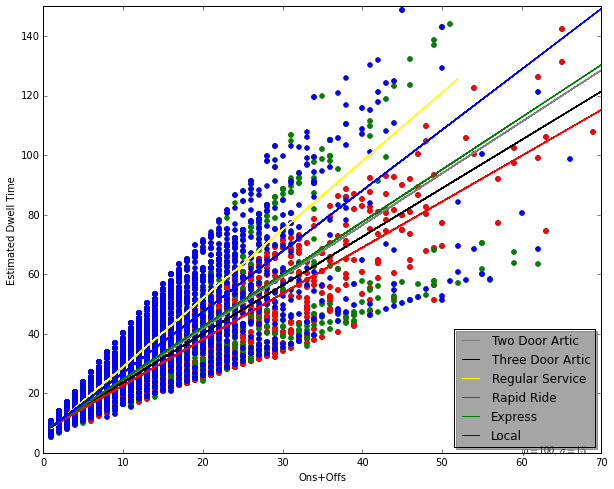

In [86]:
#Create dataframe for specific groups
test_StandardService = test[test.Artic == 0]
test_TwoDoorsArtic = test[(test.twodoors_artic == 1)]
test_ThreeDoorsArtic = test[(test.threedoors_artic == 1)]
test_RapidRide = test[test.R == 1]
test_Express = test[test.E == 1]
test_Local = test[(test.R == 0)&(test.E == 0)]

fig, ax = plt.subplots()

# plot the data itself
x1 = test_TwoDoorsArtic['ON+OFF']
y1 = test_TwoDoorsArtic['Dwell_Time_Esti']
print len(x1), len(y1)
# plot the data itself
ax.scatter(x1, y1, color = 'grey')
#plot the trend line
fit = np.polyfit(x1, y1, deg=1)
ax.plot(x1, fit[0] * x1 + fit[1], color='grey', label='Two Door Artic')

x2 = test_ThreeDoorsArtic['ON+OFF']
y2 = test_ThreeDoorsArtic['Dwell_Time_Esti']
# plot the data itself
ax.scatter(x2, y2, color = 'black')
#plot the trend line
fit = np.polyfit(x2, y2, deg=1)
ax.plot(x2, fit[0] * x2 + fit[1], color='black', label='Three Door Artic')

# plot the data itself
x3 = test_StandardService['ON+OFF']
y3 = test_StandardService['Dwell_Time_Esti']
# plot the data itself
ax.scatter(x3, y3, color = 'yellow')
#plot the trend line
fit = np.polyfit(x3, y3, deg=1)
ax.plot(x3, fit[0] * x3 + fit[1], color='yellow', label= 'Regular Service')

x4 = test_RapidRide['ON+OFF']
y4 = test_RapidRide['Dwell_Time_Esti']
# plot the data itself
ax.scatter(x4, y4, color = 'red')
#plot the trend line
fit = np.polyfit(x4, y4, deg=1)
ax.plot(x4, fit[0] * x4 + fit[1], color='red', label= 'Rapid Ride')

x5 = test_Express['ON+OFF']
y5 = test_Express['Dwell_Time_Esti']
# plot the data itself
ax.scatter(x5, y5, color = 'green')
#plot the trend line
fit = np.polyfit(x5, y5, deg=1)
ax.plot(x5, fit[0] * x5 + fit[1], color='green', label= 'Express')

x6 = test_Local['ON+OFF']
y6 = test_Local['Dwell_Time_Esti']
# plot the data itself
ax.scatter(x6, y6, color = 'blue')
#plot the trend line
fit = np.polyfit(x6, y6, deg=1)
ax.plot(x6, fit[0] * x6 + fit[1], color='blue', label= 'Local')



plt.xlabel('Ons+Offs')
plt.ylabel('Estimated Dwell Time')
plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
ax.legend(loc='lower right', shadow=True)
#plt.figure(figsize=(10,5))
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.axis([0, 70, 0, 150])

fig.show()

#three doors trend is exactly as same as rapid ride bus... 

In [531]:
print 'end'

end
